In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def add_label_noise(labels, p=0.1):
    num_labels = int(len(labels))
    num_change = int(p * len(labels))
    
    idx = torch.randperm(num_labels)[:num_change]

    new_labels = torch.randint(0, 10, (num_change,))
    labels[idx] = new_labels
    return labels
print(add_label_noise(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0]), 0.8))

trainset.targets = add_label_noise(torch.tensor(trainset.targets), p=0.2).tolist()

tensor([1, 9, 2, 2, 8, 0, 7, 2, 9, 5])


In [5]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                                
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

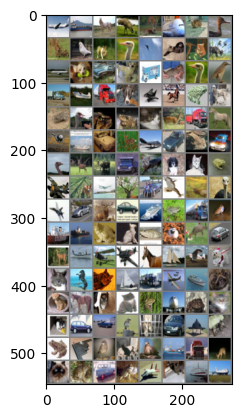

plane ship  horse bird  deer  plane cat   bird  frog  bird  cat   bird  plane cat   cat   deer  deer  dog   car   dog   truck cat   bird  bird  car   plane ship  dog   dog   horse frog  dog   frog  bird  cat   frog  cat   deer  truck dog   bird  frog  car   deer  plane car   frog  car   bird  deer  deer  truck cat   dog   cat   frog  bird  car   plane deer  truck frog  deer  bird  plane car   deer  car   ship  truck truck frog  ship  ship  frog  cat   frog  bird  deer  car   cat   cat   plane plane horse ship  plane dog   cat   horse cat   ship  truck plane ship  horse cat   frog  car   cat   frog  bird  cat   cat   plane car   car   bird  plane car   plane cat   frog  plane bird  cat   bird  ship  truck deer  cat   deer  car   frog  plane cat   ship  frog 


In [6]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from resnet import ResNet

In [8]:
net = ResNet()
net = net.to(device)

In [9]:
# print number of parameters
print(sum(p.numel() for p in net.parameters()))

11174026


In [10]:
optim = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
lossi = []
testi = []

In [12]:
def estimate_loss(split="train"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
    return loss / len(loader)

In [13]:
epochs = 64

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        lossi.append(loss.item())
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'[{epoch}, {i}] loss: {loss.item()}')

    test_loss = estimate_loss("test")
    print(f'[{epoch}] test loss: {test_loss}')
    testi.append(test_loss)


[0, 0] loss: 2.5404419898986816
[0, 200] loss: 1.81912100315094
[0] test loss: 1.3591013090519966
[1, 0] loss: 1.7130094766616821
[1, 200] loss: 1.6495137214660645
[1] test loss: 1.171884506563597
[2, 0] loss: 1.4900456666946411
[2, 200] loss: 1.3656145334243774
[2] test loss: 1.077728245831743
[3, 0] loss: 1.5229021310806274
[3, 200] loss: 1.462938904762268
[3] test loss: 1.0478171970270858
[4, 0] loss: 1.2719087600708008
[4, 200] loss: 1.264803171157837
[4] test loss: 0.9605134506768818
[5, 0] loss: 1.2429808378219604
[5, 200] loss: 1.2813559770584106
[5] test loss: 0.9100202133383932
[6, 0] loss: 1.380292534828186
[6, 200] loss: 1.3919689655303955
[6] test loss: 0.895629683627358
[7, 0] loss: 1.2665436267852783
[7, 200] loss: 1.103500485420227
[7] test loss: 0.8689866624300993
[8, 0] loss: 1.2021244764328003
[8, 200] loss: 0.9929782748222351
[8] test loss: 0.8785301197933245
[9, 0] loss: 0.9244354367256165
[9, 200] loss: 1.2060108184814453
[9] test loss: 0.8893456866469565
[10, 0] l

In [14]:
def check_accuracy(split="test"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    net.train()
    print(f'{split} accuracy: {correct / total}')
    return correct / total

check_accuracy("test")
check_accuracy("train")

test accuracy: 0.7306
train accuracy: 1.0


1.0

In [15]:
import matplotlib.pyplot as plt

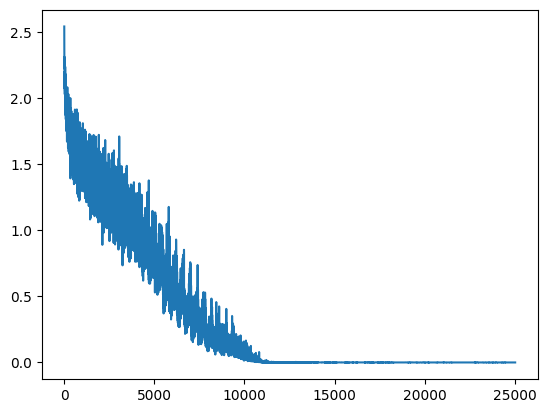

In [16]:
plt.plot(lossi)

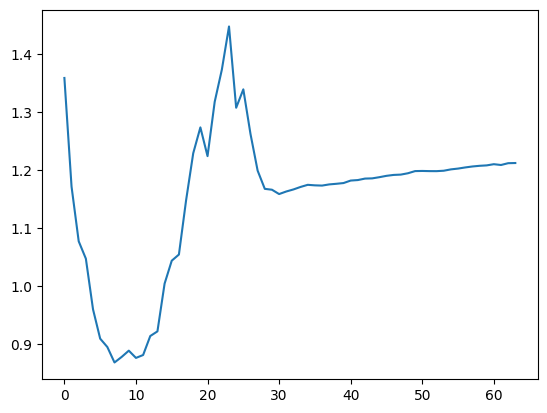

In [17]:
plt.plot(testi)